# EDA

In [1]:
# Load Libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read data
data=pd.read_csv("final_project.csv")

In [3]:
# Size
data.shape

(160000, 51)

In [4]:
# Checking Duplicates
data.duplicated().values.any()

False

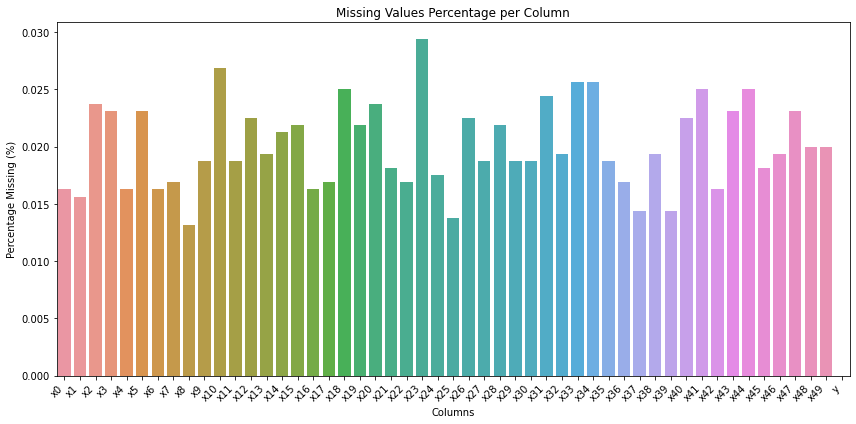

In [5]:
# Checkin percentage of missing attribute per column
missing_data = data.isnull().mean() * 100  

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_data.index, y=missing_data.values)
plt.xlabel('Columns')
plt.ylabel('Percentage Missing (%)')
plt.title('Missing Values Percentage per Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

+ There are missing variables in every feature but is very minimal
+ These will be adress as we go look through categorical features and continuous

In [6]:
# Data types
data.dtypes.value_counts()

float64    45
object      5
int64       1
dtype: int64

> ***Check Object features***

In [7]:
# Pull data categorical data 
data.select_dtypes(include='object').head()

,x24,x29,x30,x32,x37
0,euorpe,July,tuesday,0.0%,$1313.96
1,asia,Aug,wednesday,-0.02%,$1962.78
2,asia,July,wednesday,-0.01%,$430.47
3,asia,July,wednesday,0.01%,$-2366.29
4,asia,July,tuesday,0.01%,$-620.66


In [5]:
# x32 is actually numeric let change to numeric and divide time 100
data['x32']=data['x32'].str.replace('%', '').astype(float) 
data['x32']=data['x32']/100
data['x32'].dtype

dtype('float64')

In [6]:
# x37 is some money numeric featue, lets change to numeric and multiple time 100
data['x37']=data['x37'].str.replace('$','',regex=False).astype(float)
data['x37'].dtype

dtype('float64')

In [7]:
# Change title of those columns since we know what these feaures represent
data.rename(columns={'x24': 'Country','x29':'Month','x30':'Day','x32':'RatioFeature'}, inplace=True)
# fix the spelling of europe
data['Country']=data['Country'].str.replace('euorpe','europe',regex=False)

+ Definitely data from Asia it should be Dec not Dev in months

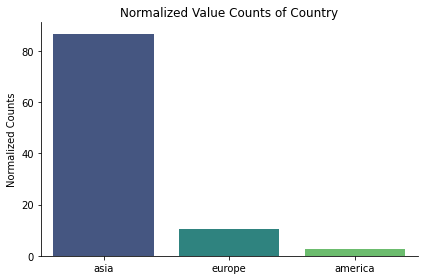

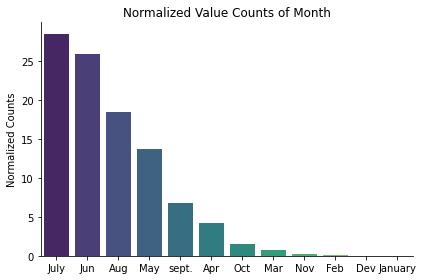

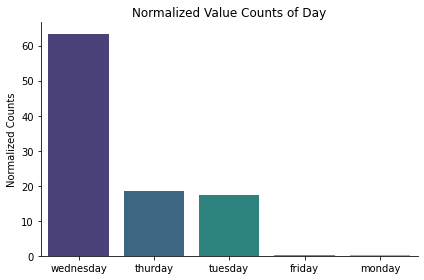

In [11]:
# Visualize each of the categorical variables
for i in data.select_dtypes(include='object').columns:
    target_dt=data[i].value_counts(normalize=True)*100
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=target_dt.index, y=target_dt.values, palette="viridis")
    plt.ylabel("Normalized Counts")
    plt.title(f'Normalized Value Counts of {i}')
    sns.despine()
    ax.yaxis.grid(False)

    plt.tight_layout()
    plt.show()
    

We can't make any claims on the validity of the features based on what would make sense given we have no information on the data, but here are the observations. 

+ Interesting to see that the week category 62% are wednesday Thursday tuesday 2 and barely any on friday and monday. Some it has to do with information about employee work
+ Most information is on the summer (May-August)
+ About 85% of data is from asia 

In [12]:
# Check total of missing variables
data.select_dtypes(include='object').isnull().sum()

Country    28
Month      30
Day        30
dtype: int64

+ Tested different combinations between Country, Month and Day and there was not enough evidence to support that there was significant association between them. Therefore can't be used to hep fill missing categorical variables
+ Given its such as numer of missing variable we will drop them

In [98]:
# Checking association to fill in missing variables
from scipy.stats import chi2_contingency

cross_tab = pd.crosstab(data['Month'], data['Day'])
_, p, _, _ = chi2_contingency(cross_tab)
p

0.9767528482572853

In [8]:
# Dropping
data.dropna(subset=['Month', 'Day', 'Country'], inplace=True)

In [9]:
# Check total of missing Categorical variables
data.select_dtypes(include='object').isnull().sum()


Country    0
Month      0
Day        0
dtype: int64

> ***Cheking Continuous Features***

+ All continuous variables have normal distribution!

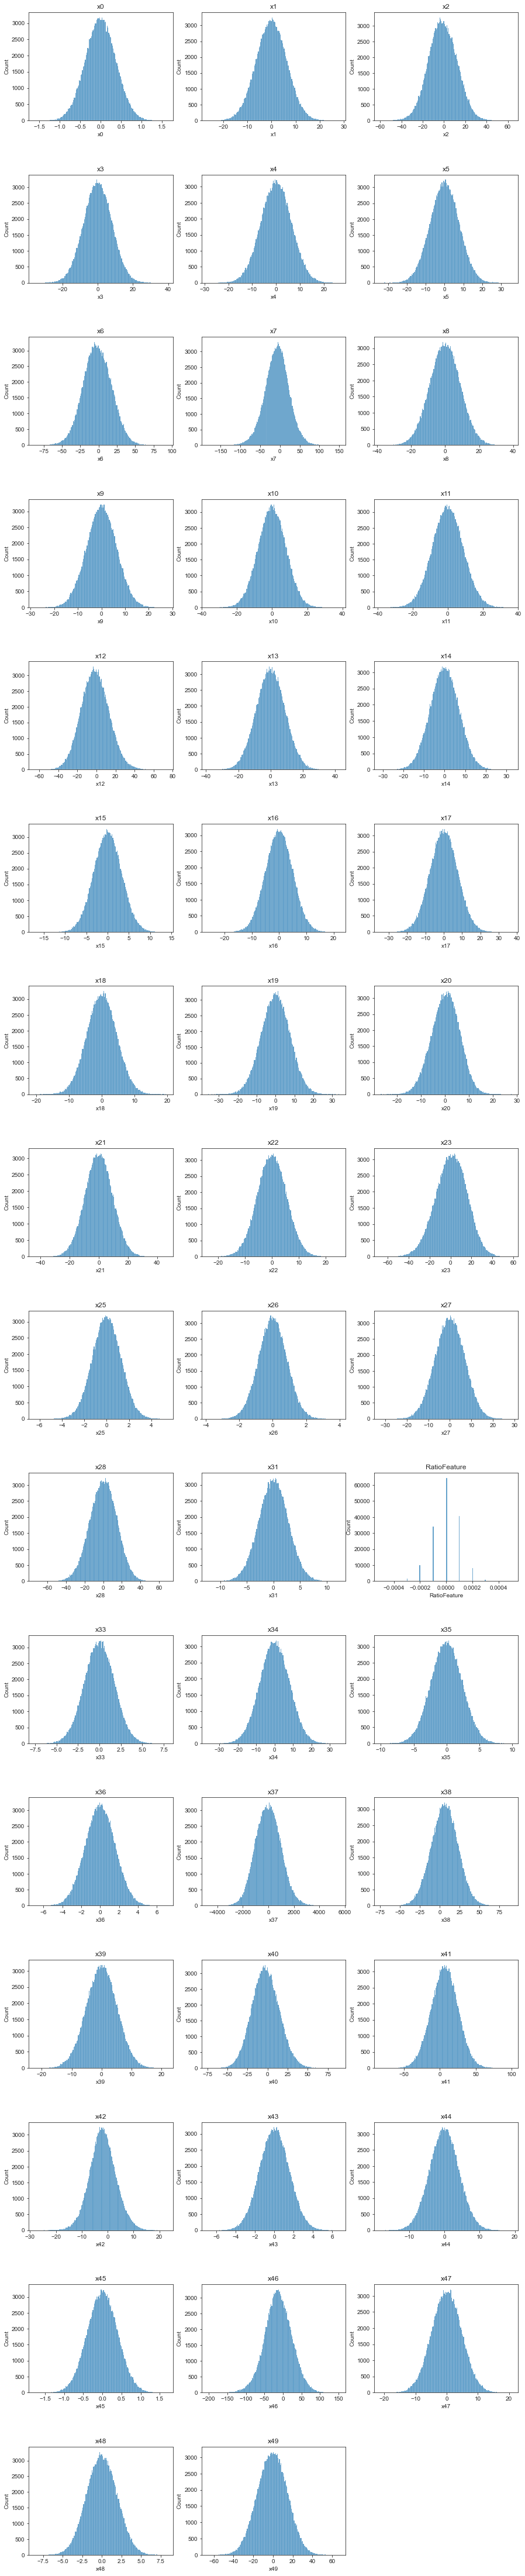

In [132]:
# Histogram of each Continuous variable
import math

num_columns = 46
num_rows = math.ceil(num_columns / 3)

plt.figure(figsize=(15, 5 * num_rows)) 

sns.set_style("ticks")
for idx, col in enumerate(data.select_dtypes(include='float64').columns, start=1):
    plt.subplot(num_rows, 3, idx)
    sns.histplot(data=data[col], kde=False)
    plt.title(col)
plt.subplots_adjust(hspace=0.5)
# plt.tight_layout()
plt.show()


+ Given its not many variables that are missing they could be dropped but we will instead auto fill with KNN imputerso to see if this helps accuracy

In [10]:
# Create deep copy
inputed_df=data.copy(deep=True)

In [11]:
# Fill missing variables
from sklearn.impute import KNNImputer
X_float64=inputed_df.select_dtypes(include='float64')
y=inputed_df['y']

imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_imputed=imputer.fit_transform(X_float64)

In [12]:
# Missing variables
X_imputed_df = pd.DataFrame(X_imputed, columns=X_float64.columns)

print("Missing values after imputation:")
print(X_imputed_df.isnull().sum().sum())

Missing values after imputation:
0


In [169]:
# Checking the features with small range to check for other ratio features. 
# The only ratio seems to be x32
for i in X_imputed_df.columns:
    if X_imputed_df[i].min()>-3:
        print(f'{i}: Min is {X_imputed_df[i].min()}, Max in {X_imputed_df[i].max()}')
        print()

x0: Min is -1.5926345910622286, Max in 1.6008494167011385

RatioFeature: Min is -0.0005, Max in 0.0005

x45: Min is -1.7532213009894346, Max in 1.6692045802039386



In [13]:
# one-hot encode
cat_df=inputed_df.select_dtypes(include='object')
cat_df = pd.get_dummies(cat_df, columns=data.select_dtypes(include=['object']).columns)

In [14]:
# Join imputed Continuous variable with categorical data
x=np.concatenate((X_imputed, cat_df.values), axis=1)

> ***Looking at the target variable***

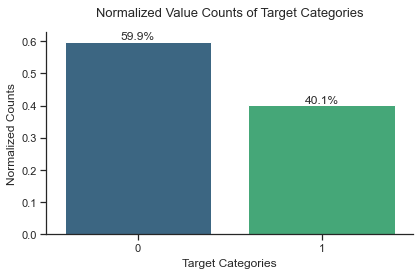

In [177]:
target_dt=data["y"].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=target_dt.index, y=target_dt.values, palette="viridis")
plt.xlabel("Target Categories")
plt.ylabel("Normalized Counts")
plt.title("Normalized Value Counts of Target Categories", y=1.05, fontsize=13)
sns.despine()
ax.yaxis.grid(False)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

plt.tight_layout()
plt.show()

> ***Run Models***

+ Random Forest
    + Let's start with ensemble robust algorithm to get a sense of the data

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, stratify=y)

In [20]:
%%time
from sklearn.model_selection import RandomizedSearchCV
my_model = RandomForestClassifier(n_jobs=-1)
params ={'n_estimators':[20], # To help it go fast
        'criterion':['gini','entropy'],
        'max_depth': [5,10,15,20,30,40],
        'min_samples_split':[16,12,10,8,6],
        'min_samples_leaf':[6,5,4,3,2],
        'max_features':[5,10,15,20,30,40]}
my_search = RandomizedSearchCV(my_model,params,n_iter=20,cv=5,n_jobs=-1)
my_search.fit(x,y)
my_search.best_estimator_


CPU times: user 3min 59s, sys: 3.7 s, total: 4min 3s
Wall time: 45min 21s


RandomForestClassifier(criterion='entropy', max_depth=30, max_features=40,
                       min_samples_leaf=3, min_samples_split=12,
                       n_estimators=20, n_jobs=-1)

In [21]:
rm_cl = RandomForestClassifier(n_estimators=100,max_depth=30,max_features=40,min_samples_leaf=3,min_samples_split=12, n_jobs=-1)
rm_cl.fit(X_train,y_train)
y_pred=rm_cl.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     28726
           1       0.93      0.89      0.91     19248

    accuracy                           0.93     47974
   macro avg       0.93      0.92      0.92     47974
weighted avg       0.93      0.93      0.93     47974



+ XG Boost
    + We know boosting can lead to slightly higher results lets try it

In [22]:
import xgboost as xgb

dtrain=xgb.DMatrix(X_train, label=y_train)
dtest=xgb.DMatrix(X_test, label=y_test)

evallist=[(dtrain,'train'),(dtest,'eval')]

num_round=100
param ={
    'objective': 'binary:logistic',
    'eval_metric': 'logloss', 
    'max_depth':10,
    'eta':0.1
}
my_model= xgb.train(param,dtrain,num_round,evals=evallist,early_stopping_rounds=2)


[0]	train-logloss:0.63567	eval-logloss:0.63920
[1]	train-logloss:0.58657	eval-logloss:0.59352
[2]	train-logloss:0.54384	eval-logloss:0.55394
[3]	train-logloss:0.50774	eval-logloss:0.52045
[4]	train-logloss:0.47534	eval-logloss:0.49091
[5]	train-logloss:0.44835	eval-logloss:0.46591
[6]	train-logloss:0.42365	eval-logloss:0.44340
[7]	train-logloss:0.40148	eval-logloss:0.42335
[8]	train-logloss:0.38057	eval-logloss:0.40441
[9]	train-logloss:0.36224	eval-logloss:0.38804
[10]	train-logloss:0.34494	eval-logloss:0.37225
[11]	train-logloss:0.32961	eval-logloss:0.35843
[12]	train-logloss:0.31583	eval-logloss:0.34637
[13]	train-logloss:0.30313	eval-logloss:0.33523
[14]	train-logloss:0.29163	eval-logloss:0.32522
[15]	train-logloss:0.28022	eval-logloss:0.31526
[16]	train-logloss:0.26955	eval-logloss:0.30608
[17]	train-logloss:0.26094	eval-logloss:0.29874
[18]	train-logloss:0.25291	eval-logloss:0.29186
[19]	train-logloss:0.24497	eval-logloss:0.28512
[20]	train-logloss:0.23684	eval-logloss:0.27836
[2

In [25]:
from sklearn.metrics import recall_score
y_pred = [1 if p > 0.5 else 0 for p in my_model.predict(dtest)]
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     28726
           1       0.93      0.90      0.92     19248

    accuracy                           0.93     47974
   macro avg       0.93      0.93      0.93     47974
weighted avg       0.93      0.93      0.93     47974



In [26]:
# Cross val

param ={
    'objective': 'binary:logistic',
    'eval_metric': 'logloss', 
    'eta':0.1
}

dmatrix = xgb.DMatrix(X_imputed, label=y)

cv_results = xgb.cv(
    params=param,
    dtrain=dmatrix,
    num_boost_round=10,  
    nfold=5,               
    metrics=['logloss', 'error', 'auc'],   
    early_stopping_rounds=10
)

# The cv_results is a DataFrame containing cross-validation results
print(cv_results)

# Extract mean accuracy and recall from cv_results
mean_accuracy = 1 - cv_results['test-error-mean'].values[-1]
mean_recall = cv_results['test-auc-mean'].values[-1]

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean AUC (Recall): {mean_recall:.4f}")


   train-logloss-mean  train-logloss-std  train-error-mean  train-error-std  \
0            0.655232           0.000633          0.208693         0.004111   
1            0.622709           0.000597          0.190930         0.003042   
2            0.594739           0.000927          0.179780         0.002685   
3            0.570718           0.000628          0.176508         0.001071   
4            0.549219           0.000456          0.171341         0.001971   
5            0.530009           0.000562          0.166857         0.001668   
6            0.512655           0.000883          0.164226         0.002089   
7            0.496628           0.000526          0.159682         0.001325   
8            0.482387           0.000931          0.156999         0.001415   
9            0.469702           0.001075          0.155324         0.001614   

   train-auc-mean  train-auc-std  test-logloss-mean  test-logloss-std  \
0        0.846454       0.003738           0.655862      

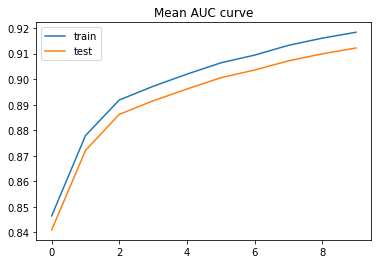

In [27]:
plt.plot(cv_results['train-auc-mean'],label='train')
plt.plot(cv_results['test-auc-mean'],label='test')
plt.title("Mean AUC curve")
plt.legend()
plt.show()

+ Dense Neural Network
    + Let's try more complex

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

In [ ]:
model_sc=tf.keras.Sequential()
model_sc.add(layers.Dense(100,activation='tanh'))
model_sc.add(layers.Dropout(.3))
model_sc.add(layers.Dense(1,activation='sigmoid'))

model_sc.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.binary_crossentropy,
                 metrics=['accuracy'])

+ x6 and x2 have 100% correlations
+ x41 and x38 have 100% correlations

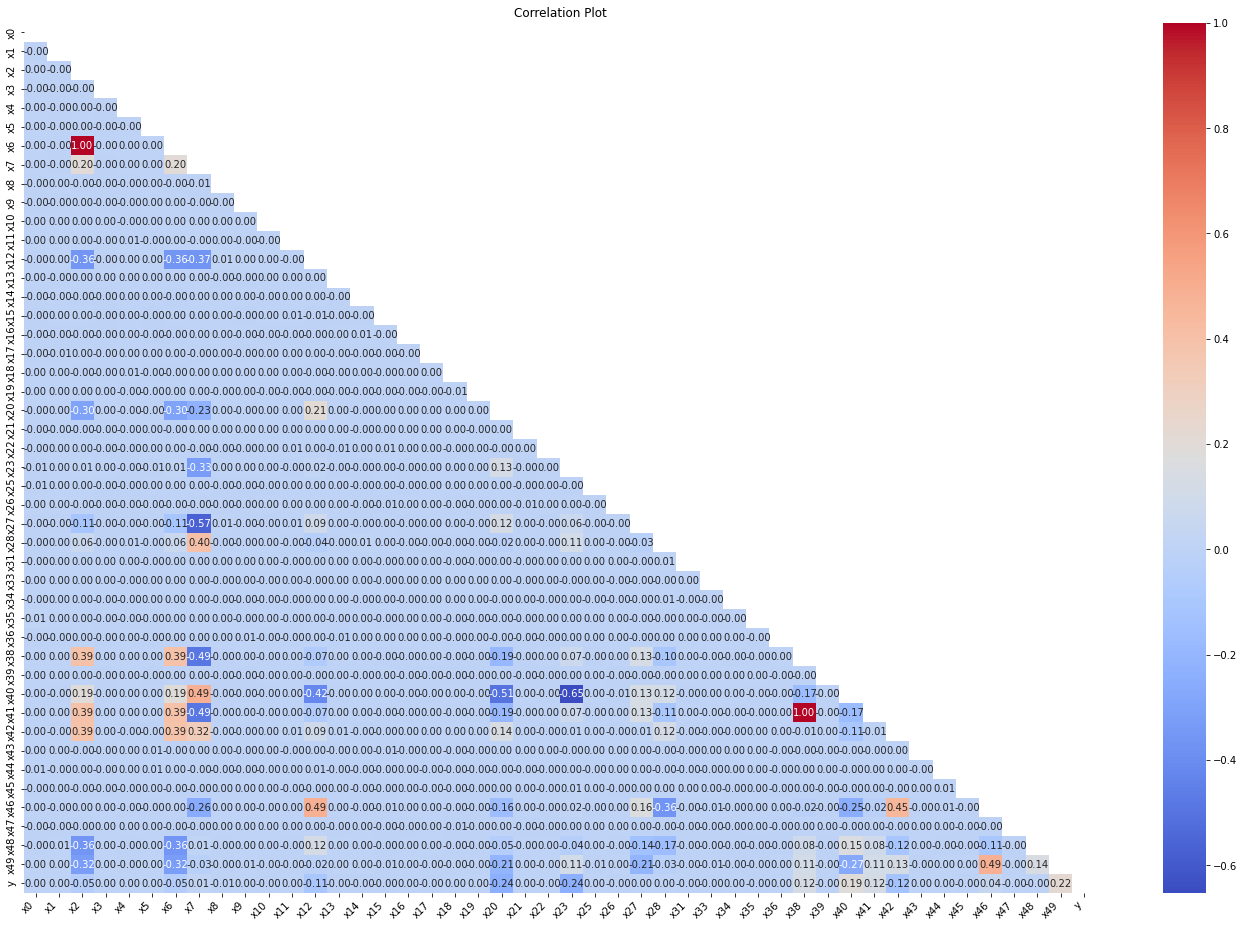

In [43]:
corr_matrix = data.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(25, 6))  

# Create the correlation plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

plt.xticks(rotation=45, ha='right')
plt.title('Correlation Plot')
plt.show()

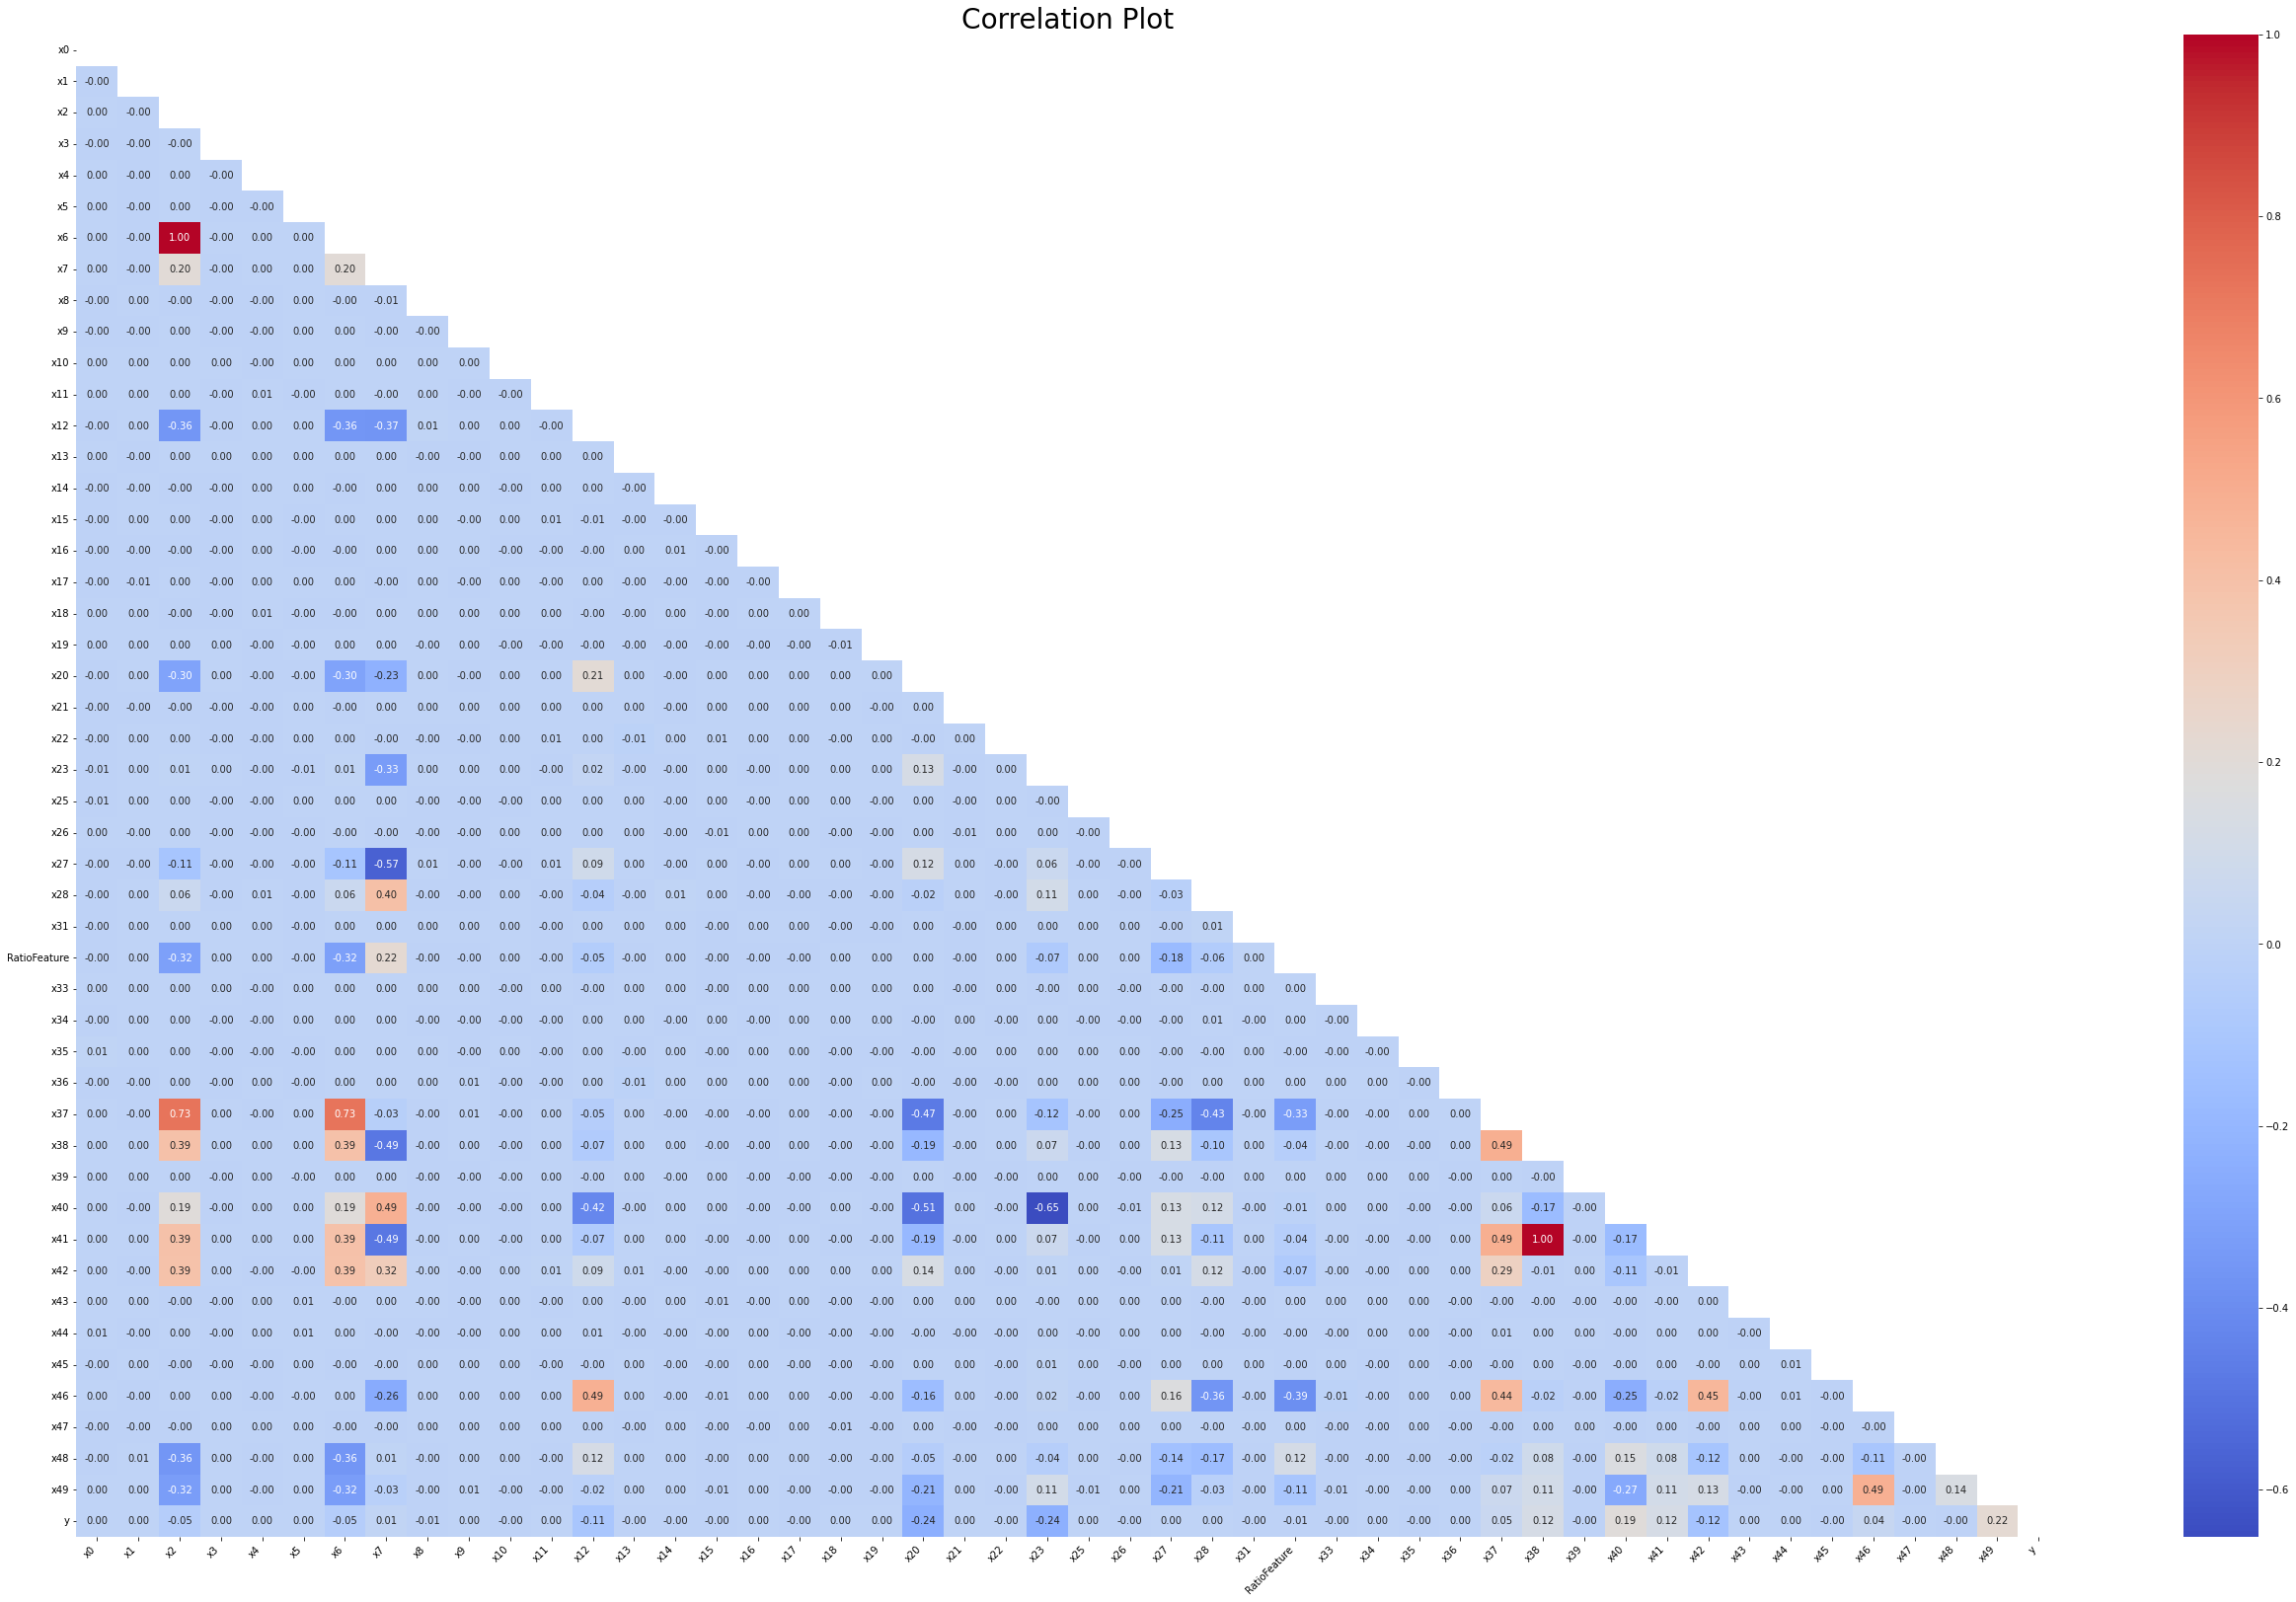

In [42]:
# Check correlation
corr_matrix = data.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(45, 28))  

# Create the correlation plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

plt.xticks(rotation=45, ha='right')
plt.title('Correlation Plot', fontsize=28)
plt.show()